In [1]:
# Modules to import: 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import model_selection 
from sklearn import linear_model
import math 


In [11]:
# import raw data set - this data represents California Housing Values for 1990 and was first generated by Pace and Barry - Statistics
# and Probability Letters, 33, 291 - 297
 
house_dat  = pd.read_csv('https://raw.githubusercontent.com/krispad/Machine_Learning/master/housescal.txt', sep = ' ')

In [3]:
# Apply function 'col_alt' to  'house_dat'  

#'col_alt' introduces features into the data and creates a modelling data set; e.g., modifies the dataset 'house_dat'(inplace ) 

def col_alt(dat, cols, adj_cols):
    ''' Arguments -
        dat: data
        cols: a list of cols to be adjusted to form new columns, e.g. for the dataset 'house_dat', cols = ['total_rooms', 'total_bedrooms', 'population']
        adj_cols: list of columns used to adjust 'cols', e.g., adj_cols= ['households']                                                                                               
    '''
    for name in cols: 
         # adjustments 
         a = dat[name]/dat[adj_cols[0]]
         dat.insert(value = a, column = 'avg_{}'.format(name), loc = dat.shape[1])
         dat.drop(labels = name, axis = 1, inplace = True)
    # Create a new feature (col)      
    b = [math.log(x) for x in dat[adj_cols[0]]]
    dat.insert(value = b , column = 'log_households', loc = dat.shape[1]) # log of the number of 'households' with the same 'house_value' in the lat/long region. 
    dat.drop(labels = 'households', axis = 1, inplace = True)

    return(dat)

# Application of the function col_alts to the dataset house_dat -- results in  'in place' changes to house_dat
col_alt(dat = house_dat, cols = ['total_rooms', 'total_bedrooms', 'population'], adj_cols = ['households']) 

,house_value,median_income,housing_median_age,latitude,longitude,avg_total_rooms,avg_total_bedrooms,avg_population,log_households
0,452600.0,8.3252,41,37.88,-122.23,6.984127,1.023810,2.555556,4.836282
1,358500.0,8.3014,21,37.86,-122.22,6.238137,0.971880,2.109842,7.037028
2,352100.0,7.2574,52,37.85,-122.24,8.288136,1.073446,2.802260,5.176150
3,341300.0,5.6431,52,37.85,-122.25,5.817352,1.073059,2.547945,5.389072
4,342200.0,3.8462,52,37.85,-122.25,6.281853,1.081081,2.181467,5.556828
...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25,39.48,-121.09,5.045455,1.133333,2.560606,5.799093
20636,77100.0,2.5568,18,39.49,-121.21,6.114035,1.315789,3.122807,4.736198
20637,92300.0,1.7000,17,39.43,-121.22,5.205543,1.120092,2.325635,6.070738
20638,84700.0,1.8672,18,39.43,-121.32,5.329513,1.171920,2.123209,5.855072


We intrepret 'households' as a household of a family (families). 
The population counts appear to be based on the individuals living within a designated lat/long designation. 
Households with an average population of greater than 12 are deemed 'unusual' -- the associated households could be retirement centers, the extra population 'homeless' or living in tent cities, etc.

#### Questions one may ask of the data:
- Does 'households' include a count of caravans in trailer parks ?

- Does 'total_rooms', 'total_bedrooms' include a count of the rooms in hotels, motels or inns ?

In [4]:
# Introducing 'NaN' values
# We define a household as a dwelling with no more than 12 people
'''
Insert 'NaN's where the calculated average population per household is greater than 12;  when  'avg_total_rooms' 
> 15 and when 'avg_total_bedrooms' > 8
'''

ind = house_dat['avg_population'] > 12
house_dat.loc[ind, 'avg_population'] = 'NaN'
ind = house_dat['avg_total_rooms'] > 15
house_dat.loc[ind, 'avg_total_rooms'] = 'NaN'
ind = house_dat['avg_total_bedrooms'] > 8
house_dat.loc[ind, 'avg_total_bedrooms'] = 'NaN'
house_dat.info() # check 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   house_value         20640 non-null  float64
 1   median_income       20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   latitude            20640 non-null  float64
 4   longitude           20640 non-null  float64
 5   avg_total_rooms     20640 non-null  object 
 6   avg_total_bedrooms  20640 non-null  object 
 7   avg_population      20640 non-null  object 
 8   log_households      20640 non-null  float64
dtypes: float64(5), int64(1), object(3)
memory usage: 1.4+ MB


In [5]:
#Identifying the entries equal to 'NaN' in the house_dat dataset. 
na_ind = house_dat.iloc[:, :] == 'NaN'

# The number of 'NA' entries for each column is listed below
na_ind.sum(axis = 0)

# Note : house_dat has 'NaN' entries for the variables 'avg_population', 'avg_total_rooms', 'avg_total_bedrooms'


#####                Imputation of values marked as 'NaN' in 'house_dat'
    
X_house = pd.DataFrame(house_dat[['longitude', 'latitude', 'log_households', 'avg_total_rooms', 'avg_total_bedrooms', 'avg_population', 
                                        'median_income', 'housing_median_age']])
y_house = pd.Series(house_dat['house_value']) # has no missing values

X_na_ind = X_house.iloc[:, :] == 'NaN'

##### Imputation 
# transforming 'NaN' values to nan values as required by the imputation algorithms on sklearn.
X_house[X_na_ind] = np.nan  

# Impute the data using the nearest neighbour imputer in sklearn
# We need only apply the imputer to X_house (since y_house has no 'NaN' entries)

from sklearn.impute import KNNImputer 
imputer = KNNImputer(n_neighbors = 2)
X_house_imputed = pd.DataFrame(data = imputer.fit_transform(X_house), columns = imputer.feature_names_in_)


X_house.info() # check


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   log_households      20640 non-null  float64
 3   avg_total_rooms     20531 non-null  object 
 4   avg_total_bedrooms  20624 non-null  object 
 5   avg_population      20608 non-null  object 
 6   median_income       20640 non-null  float64
 7   housing_median_age  20640 non-null  int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 1.3+ MB


#### Modelling the California House Values using a Gamma Distributed GLM
 
- CROSS-VALIDATION RESULTS ARE PRESENTED
- GLM Results 
- Plots on Validation Results
- Commentary
       


In [6]:
from sklearn import preprocessing

# Scaling the numerical data and applying the GammaRegressor 
# 1) Apply the scaler to the imputed house data 

scale = sk.preprocessing.StandardScaler()
# scaled_data produces a numpy array
scaled_data = scale.fit_transform(X_house_imputed, y_house) # standard scaler applied to all the variables (which are numeric).
tweedie = linear_model.TweedieRegressor(link = 'log', power = 2, max_iter = 100)

house_cv = model_selection.cross_validate(tweedie, X = scaled_data, y = y_house,
                                          cv = 3, scoring = ['r2', 'neg_mean_gamma_deviance', 'neg_root_mean_squared_error'])
house_cv

In [11]:
# Using the STATSMODEL API for 'traditional statistics ' and using python code, 
# In particular we present summaries of GLMs (wee subsequently compare this with the R implementation of GLM)

import statsmodels.api as sm 
'''  Creating endogoneous ( response)  and exogeneous (explanatory) variables: '''

# Use the imputed data viz., X_house,(explanatory) , y_house ( response) 
       
house_endog = y_house # response variable 
house_exog = sm.add_constant(X_house_imputed, prepend = False)    #  Adding explanatory variables + constant

           ###################### Model GLM ################################

house_sm_glm = sm.GLM(house_endog, house_exog, family = sm.families.Gamma(sm.families.links.log())) 
house_sm_rslts = house_sm_glm.fit()
house_sm_rslts.summary()

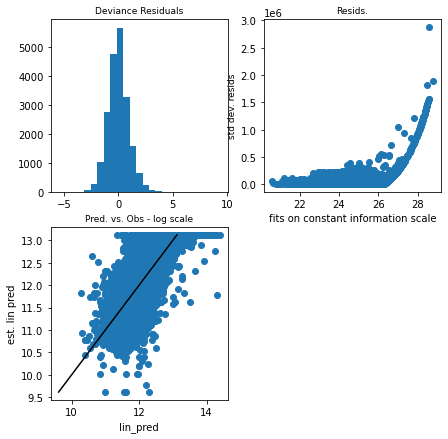

In [12]:
################### Validation Plots ##################

# A function to calculate the standard deviance residuals from a GLM fit.
def std_dev_resid(fitted_values, resid_dev, diag_hatmatrix):
    numer = [x*abs(y) for (x, y) in zip(fitted_values, resid_dev)]
    denom = [math.sqrt(1-x) for x in diag_hatmatrix]
    std_dev_resid = [round(x/y, ndigits = None) for (x, y) in zip(numer, denom)]
    return(std_dev_resid)

# Calculating the standard residual 
stdized_dev = std_dev_resid(
                                fitted_values = house_sm_rslts.fittedvalues
                              , resid_dev = house_sm_rslts.resid_deviance 
                              , diag_hatmatrix = house_sm_rslts.get_hat_matrix_diag()
                           )

# Need to import the 'stats' module from scipy to 'normalize' the data 
from scipy import stats

fig, ax  = plt.subplots(2, 2, figsize = (7, 7))

# the deviance used are unstandardized
# stats.zscore calculates the zscore(assuming the t-distribution) of the sample entries. 
ax[0, 0].hist(stats.zscore(house_sm_rslts.resid_deviance), bins = 25)
ax[0, 0].set_title('Deviance Residuals', fontsize = 9)


b = house_sm_rslts.fittedvalues

# Informal checks;  namely plots of the residuals to assess fit 
 
# calulating the constant information scale 
d = [2*math.log(x) for x in b]
a = house_dat['house_value']
c = stdized_dev

# 1.standardized dev. residuals vs. fitted values on constant information scale
ax[0, 1].scatter(y = c, x = d)
ax[0, 1].set_title('Resids.', fontsize = 9)
ax[0, 1].set_xlabel('fits on constant information scale')
ax[0,1].set_ylabel('std dev. resids', fontsize = 9)

# 2. linear predictor vs. estimated linear predictor.
lin_pred = [math.log(x) for x in house_dat['house_value']]

est_lin_pred = [math.log(x) for x in house_sm_rslts.fittedvalues]

# 3. Scatter Plot 
mn = min(lin_pred)
mx = max(lin_pred)
ax[1, 0].scatter(x = est_lin_pred, y = lin_pred)
ax[1, 0].set_ylabel('est. lin pred')
ax[1, 0].set_xlabel('lin_pred')
ax[1, 0].set_title('Pred. vs. Obs - log scale', fontsize = 9)
ax[1, 0].plot([mn, mx], [mn, mx], color = 'black')   
ax[1, 1].remove()

#### Commentary on the results of the GLM 

##### Cross-Validation 
- At worst the r^2 value is .27 
- The largest mean squared error is 101000
##### Model Summary Results
- A very large value for the constant in the linear predictor 
##### Plots 
###### 2D plots 
####### Commentary on the informal checks on the model adequacy and residuals
- The standardized deviance residuals are constant up to a constant information scale (2*log(z)) value of 21. After 21, the standardized residuals increase (approximately) stepwise as a function of the constant information scale up to about 26; after 26, they follow a distinct pattern. This may indicate an inadequate variance function, linear predictor or insufficient covariates (explanatory variables).
- Examination of the predicted values against the observed indicates condsiderable variance about the line est_lin_pred = lin_pred; this may be due to inadequate explanatory variables.

In [18]:
#######################  Partial Dependence Plots of the fitted model --- 3D Plots ###########################################
### We illustrate, in the fitted model,  an example of interaction between explanatory variables
## This may account for the lack of fit in the GLM --- At a later stage we use a Machine Learning Technique to try and avoid this issue.

# We consider variables:'fitted_values', 'avg_population', and 'housing_median_age'
 
# First round the digits in 'fitted_values' and 'avg_population'
X_house_imputed['fitted_values'] =pd.Series([round(x, ndigits = 2) for x in house_sm_rslts.fittedvalues])
X_house_imputed['avg_population'] = pd.Series([round(x, ndigits = 2) for x in X_house_imputed['avg_population']])


# plot a 3D surface 

U = np.linspace(min(X_house_imputed['housing_median_age']), max(X_house_imputed['housing_median_age']), 30)
V = np.linspace(min(X_house_imputed['avg_population']), max(X_house_imputed['avg_population']), 30)


X, Y = np.meshgrid(U, V)

# Generation of the Z value, that is the response as function of 'house_median_age' and 'avg_population' while averaging over remaining explanatory variables in the model

# Calculating the contribution (averages over the collected data) of the fixed variables in the glm model and calculating
# the estimated linear predictor as a function of the free variables 

a = np.array(X_house_imputed[['longitude', 'latitude', 'median_income', 'avg_total_rooms', 'avg_total_bedrooms', 'log_households']].mean())

b = np.array(house_sm_rslts.params.loc[['longitude', 'latitude', 'median_income', 'avg_total_rooms', 'avg_total_bedrooms', 'log_households'], ])

c = sum(a*b)
def f(x,y):
    import math
    z =  house_sm_rslts.params.loc['const', ] + c + sum(np.array(house_sm_rslts.params.loc[['housing_median_age','avg_population'], ])*np.array((x, y)))
    val = round(math.exp(z)/100000, ndigits = 2)
    
    return(val)

# list generation 

def tst(X, Y): # X, Y lists

   
     c = [f(x, y) for x, y  in zip(X, Y)]
   
     return(c)
def z_rslt(X, Y):
    
    z = []
    for i in range( len(X)):
        c = tst(X[i], Y[i])
        z.append(c)
    z = np.array(z)
    return(z)
         
Z = z_rslt(X, Y)

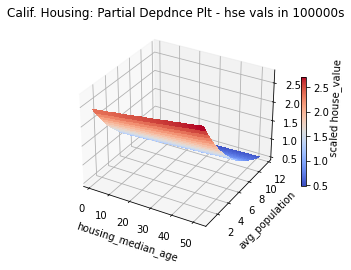

In [17]:
# Plot a surface plot 

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('housing_median_age')
ax.set_ylabel('avg_population')
ax.set_zlabel('scaled house_value', labelpad = 18.0)
ax.set_title('Calif. Housing: Partial Depdnce Plt - hse vals in 100000s')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=25, spacing = 'proportional')

plt.show()
